# Test add bar

In [1]:
import os
import fire
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imread
from skimage.io import imsave, imshow
from skimage.transform import resize
from mimic_constants import *
from sklearn.preprocessing import QuantileTransformer

In [23]:
def preprocess_no_bars(df, out_dir, verbose=False):
    df_cxr = df.copy()
    img_type = 'xray'
    suffix = 'no_bars'
    df_cxr['path_preproc'] = df_cxr['path']

    preproc_dir = get_preproc_subpath(img_type, suffix)

    print(f'Image Type: {img_type}s with no barcodes')
    print(f'preproc_dir: {out_dir / preproc_dir}')
    
    if not verbose:
        os.makedirs(out_dir/ preproc_dir, exist_ok=True)

    for idx, p in enumerate(tqdm(df_cxr['path'])):
        out_path = construct_preproc_path(p, out_dir, preproc_dir)

        if (not os.path.exists(out_path)) or verbose:
            height = 224; width = 224
            image = imread(scratch_dir / p)  # og chexpert imagery is on scratch
            image = resize(image, output_shape=(height, width), preserve_range=True)
            image = np.expand_dims(image, axis=2).repeat(3, axis=2)

            if verbose:
                imshow(image.astype(np.uint8))
            else:  
                imsave(out_path, image.astype(np.uint8))

def preprocess_mimic_df(idp=False, order=None, bar_vars=significant_variables, label='Cardiomegaly', verbose=False):
    variables = np.array(bar_vars)
    order, suffix = get_barcode_order_info(order, bar_vars)
    
    df_master = get_master_df(idp=idp)
    if not idp:
        df_master = df_master[df_master[label].isin([0, 1])]
        study_year = np.floor(df_master['StudyDate'] / 10000)
        delta_years = study_year - df_master['anchor_year']
        df_master['age'] = df_master['anchor_age'] + delta_years
    else:
        df_master['age'] = df_master['anchor_age']

    
    # normalize age as in chexpert (0-100 to 0-1)
    df_master['age_val'] = df_master['age'].apply(lambda x: min(x / 100, 1))
    # quantile normalize the rest
    for var in bar_vars[1:]:
        transformer = QuantileTransformer(output_distribution='uniform')
        df_master.loc[:, var] = transformer.fit_transform(df_master[[var]])

    df = df_master[['path'] + bar_vars]

    if verbose:
        print(df.head())
        print(variables[order].tolist())
    
    return df[['path'] + variables[order].tolist()[0]]

def npy_bar(data, colormap, img_w=500, img_h=100, add_label=False, add_colormap=False, verbose=False):
    variables = data.columns[1:]  # Exclude ID
    print(data.columns)
    variables = variables[::-1]  # Bars generated bottom to top

    for index, row in data.iterrows():
        px = 1/plt.rcParams['figure.dpi']  # pixel in inches
        bar_height = 1.0  # Height of each bar -- keep it to 1.0 to ensure no gap
        if verbose:
            fig, ax = plt.subplots(figsize=(10, 5))
        else:
            fig, ax = plt.subplots(figsize=(img_w*px, img_h*px))

        # Create horizontal bar plot
        for i, var in enumerate(variables):
            value = row[var]
            print(var, value)
            if np.isnan(value):
                color = 'r'  # i.e. 'red'
            else:
                color = colormap(value)
            ax.barh(i, 1, color=color, height=bar_height, edgecolor='none')

        # Set y-ticks and labels
        if add_label:
            ax.set_yticks(np.arange(len(variables)))
            ax.set_yticklabels(variables)
        else:
            ax.set_yticks([])

        # Remove grid and axes
        ax.grid(False)
        ax.set_xticks([])
        ax.set_xlim(0, 1)

        # Remove spines
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Add colorbar
        if add_colormap:
            sm = plt.cm.ScalarMappable(
                cmap=colormap, norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.04)
            cbar.set_label('Normalized feature value')

        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        fig.canvas.draw()
        if add_label or add_colormap:
            plt.show()
        else:
            bar_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            # slicing removes whitespace from bars; need to redo if bar size is changed
            bar_img = bar_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[3:-2, :, :3]
            plt.close(fig)
        
            if verbose:
                print(bar_img.shape)
                imshow(bar_img.astype(np.uint8))

            return bar_img

def preprocess_and_append_bars(df, img_type, img_data_dir, idp=False, order=None, bar_vars=significant_variables, colormap=plt.colormaps['binary'], verbose=False):
    df_cxr = df.copy()
    out_dir = img_data_dir

    order, suffix = get_barcode_order_info(order)
    preproc_dir = get_preproc_subpath(img_type, suffix)

    print(f'Image Type: {img_type}')
    print(f"Barcode Order: {suffix.replace('_', ', ')}")
    print(f'preproc_dir: {out_dir / preproc_dir}')
    
    bars_h = int(0.2 * 224) # 44
    whitespace_offset = 5 + 1 # num of pixel rows removed from bar output + 1 (row to remove because resizing artifact)

    if not verbose:
        os.makedirs(out_dir/ preproc_dir, exist_ok=True)

    for idx, p in enumerate(tqdm(df_cxr['path'])):
        out_path = construct_preproc_path(p, out_dir, preproc_dir)

        if (not os.path.exists(out_path)) or verbose:
            height = 224 + whitespace_offset - bars_h; width = 224
            if img_type == 'xray':
                image = imread(scratch_dir / p)  # og chexpert imagery is on scratch
                image = resize(image, output_shape=(height, width), preserve_range=True)
                image = np.expand_dims(image, axis=2).repeat(3, axis=2)
            elif img_type == 'noise':
                # Generate random noise
                image = np.random.randint(low=0, high=255, size=(height, width)) # 1-channel, B/W noise
                image = np.expand_dims(image, axis=2).repeat(3, axis=2)  # make it 3-channel
            elif img_type == 'blank':
                image = np.zeros(shape=(height, width, 3))  # all black image

            image = image[:-1,:,:]  # remove last img row (gets rid of resizing artifacts)

            # Generate the barcode and append it to the bottom of the image
            bar_img = npy_bar(df_cxr.iloc[[idx]], colormap, img_h=bars_h, img_w=width)
            
            combined_img = np.concatenate((image, bar_img), axis=0)
            
            if verbose:
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                ax.imshow(combined_img.astype(np.uint8))
                y_ticks = range(0, 224, 10)
                plt.yticks(y_ticks)
                #plt.tick_params(axis='y', labelsize=5)
                fig.tight_layout()
                plt.show()
            else:
                imsave(out_path, combined_img.astype(np.uint8))

In [3]:
df_cxr = preprocess_mimic_df(idp=True, verbose=False)
print(df_cxr.shape)
df_cxr.head()

(2662, 9)


,path,age_val,Chloride_mean,RR_mean,Urea_Nitrogren_mean,Magnesium_mean,Glucose_mean,Phosphate_mean,Hematocrit_mean
0,files/p10/p10001884/s55333410/5b135035-4708084...,0.77,0.124027,0.484323,0.575318,0.733196,0.773585,0.306329,0.426632
1,files/p10/p10002013/s52163036/1e647043-eed3576...,0.57,0.509510,0.077055,0.265265,0.582082,0.893887,NaN,0.545546
2,files/p10/p10004457/s55439624/ad41d9ed-37ff140...,0.66,0.544545,0.069201,0.336722,0.925425,0.247247,0.643644,0.173173
3,files/p10/p10011365/s56594284/ff295ca5-9f888b5...,0.82,0.862863,0.763676,0.269241,0.764765,0.717168,0.046521,0.515735
4,files/p10/p10012292/s52412975/ca16ea39-8c22bfd...,0.72,0.936937,0.867930,0.767768,0.273774,0.662663,0.661662,0.331506


In [4]:
i = 1
df_cxr[i:i+1]

,path,age_val,Chloride_mean,RR_mean,Urea_Nitrogren_mean,Magnesium_mean,Glucose_mean,Phosphate_mean,Hematocrit_mean
1,files/p10/p10002013/s52163036/1e647043-eed3576...,0.57,0.50951,0.077055,0.265265,0.582082,0.893887,NaN,0.545546


Image Type: xrays with no barcodes
preproc_dir: /n/no_backup2/patel/ays124/mimic-dataset/preproc_224x224_xray_no_bars


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


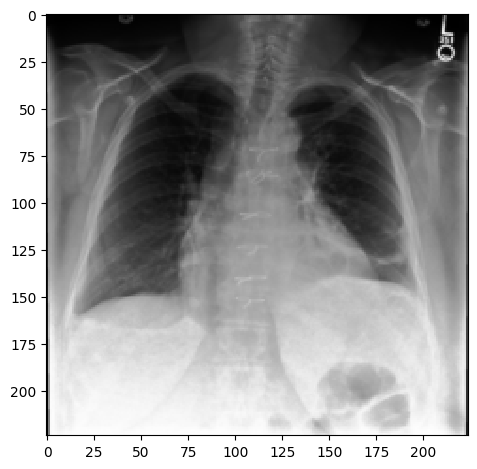

In [5]:
preprocess_no_bars(df_cxr[i:i+1], out_dir=nb_group_dir, verbose=True)

Image Type: xray
Barcode Order: age, chloride, rr, urea, nitrogren, magnesium, glucose, phosphate, hematocrit
preproc_dir: /n/no_backup2/patel/ays124/mimic-dataset/preproc_224x224_xray_age_chloride_rr_urea_nitrogren_magnesium_glucose_phosphate_hematocrit


  0%|          | 0/1 [00:00<?, ?it/s]

Index(['path', 'age_val', 'Chloride_mean', 'RR_mean', 'Urea_Nitrogren_mean',
       'Magnesium_mean', 'Glucose_mean', 'Phosphate_mean', 'Hematocrit_mean'],
      dtype='object')
Hematocrit_mean 0.5455455455455456
Phosphate_mean nan
Glucose_mean 0.8938872722611649
Magnesium_mean 0.582082082082082
Urea_Nitrogren_mean 0.2652652652652653
RR_mean 0.07705453090899907
Chloride_mean 0.5095095095095095
age_val 0.57


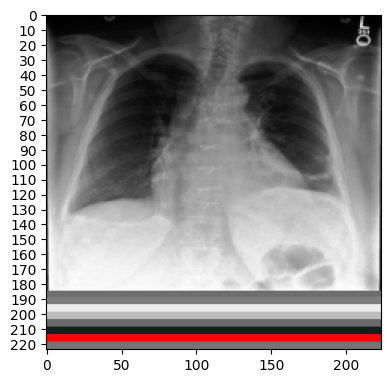

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


In [24]:
preprocess_and_append_bars(df_cxr[i:i+1], img_type='xray', img_data_dir=nb_group_dir, verbose=True)

Image Type: noise
Barcode Order: age, chloride, rr, urea, nitrogren, magnesium, glucose, phosphate, hematocrit
preproc_dir: /n/no_backup2/patel/ays124/mimic-dataset/preproc_224x224_noise_age_chloride_rr_urea_nitrogren_magnesium_glucose_phosphate_hematocrit


  0%|          | 0/1 [00:00<?, ?it/s]

Index(['path', 'age_val', 'Chloride_mean', 'RR_mean', 'Urea_Nitrogren_mean',
       'Magnesium_mean', 'Glucose_mean', 'Phosphate_mean', 'Hematocrit_mean'],
      dtype='object')


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

Hematocrit_mean 0.5455455455455456
Phosphate_mean nan
Glucose_mean 0.8938872722611649
Magnesium_mean 0.582082082082082
Urea_Nitrogren_mean 0.2652652652652653
RR_mean 0.07705453090899907
Chloride_mean 0.5095095095095095
age_val 0.57


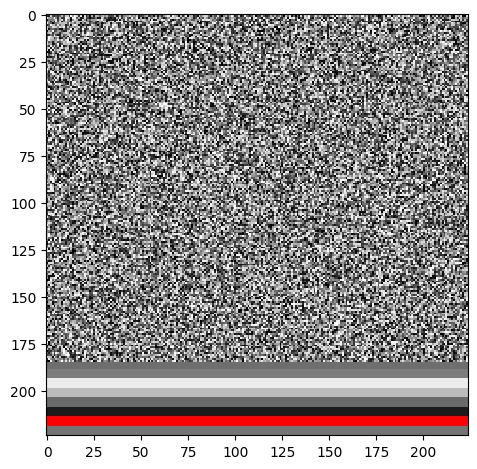

In [31]:
preprocess_and_append_bars(df_cxr[i:i+1], img_type='noise', img_data_dir=nb_group_dir, verbose=True)

Image Type: blank
Barcode Order: age, chloride, rr, urea, nitrogren, magnesium, glucose, phosphate, hematocrit
preproc_dir: /n/no_backup2/patel/ays124/mimic-dataset/preproc_224x224_blank_age_chloride_rr_urea_nitrogren_magnesium_glucose_phosphate_hematocrit


  0%|          | 0/1 [00:00<?, ?it/s]

Index(['path', 'age_val', 'Chloride_mean', 'RR_mean', 'Urea_Nitrogren_mean',
       'Magnesium_mean', 'Glucose_mean', 'Phosphate_mean', 'Hematocrit_mean'],
      dtype='object')
Hematocrit_mean 0.5455455455455456
Phosphate_mean nan
Glucose_mean 0.8938872722611649
Magnesium_mean 0.582082082082082
Urea_Nitrogren_mean 0.2652652652652653
RR_mean 0.07705453090899907
Chloride_mean 0.5095095095095095
age_val 0.57


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


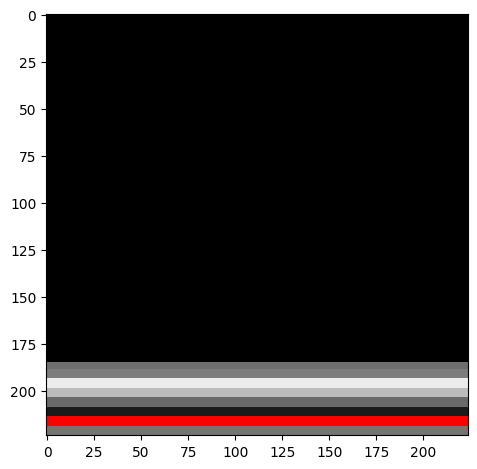

In [32]:
preprocess_and_append_bars(df_cxr[i:i+1], img_type='blank', img_data_dir=nb_group_dir, verbose=True)

# Old bugfinding code

<Axes: >

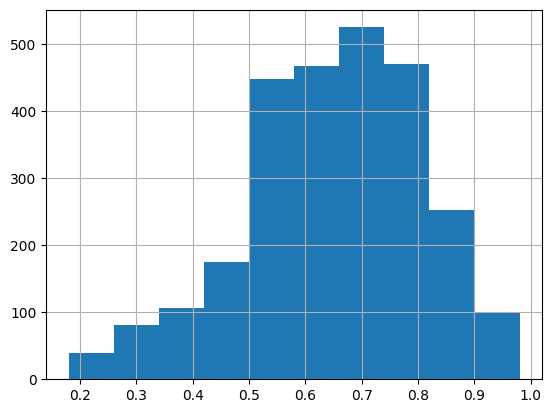

In [38]:
df_cxr['age_val'].hist()

In [34]:
df_cxr[i:i+1]

,path,age_val,Chloride_mean,RR_mean,Urea_Nitrogren_mean,Magnesium_mean,Glucose_mean,Phosphate_mean,Hematocrit_mean
1,files/p10/p10002013/s52163036/1e647043-eed3576...,0.57,0.50951,0.077055,0.265265,0.582082,0.893887,NaN,0.545546


Index(['path', 'age_val', 'Chloride_mean', 'RR_mean', 'Urea_Nitrogren_mean',
       'Magnesium_mean', 'Glucose_mean', 'Phosphate_mean', 'Hematocrit_mean'],
      dtype='object')
Hematocrit_mean 0.5455455455455456
Phosphate_mean nan
Glucose_mean 0.8938872722611649
Magnesium_mean 0.582082082082082
Urea_Nitrogren_mean 0.2652652652652653
RR_mean 0.07705453090899907
Chloride_mean 0.5095095095095095
age_val 0.57


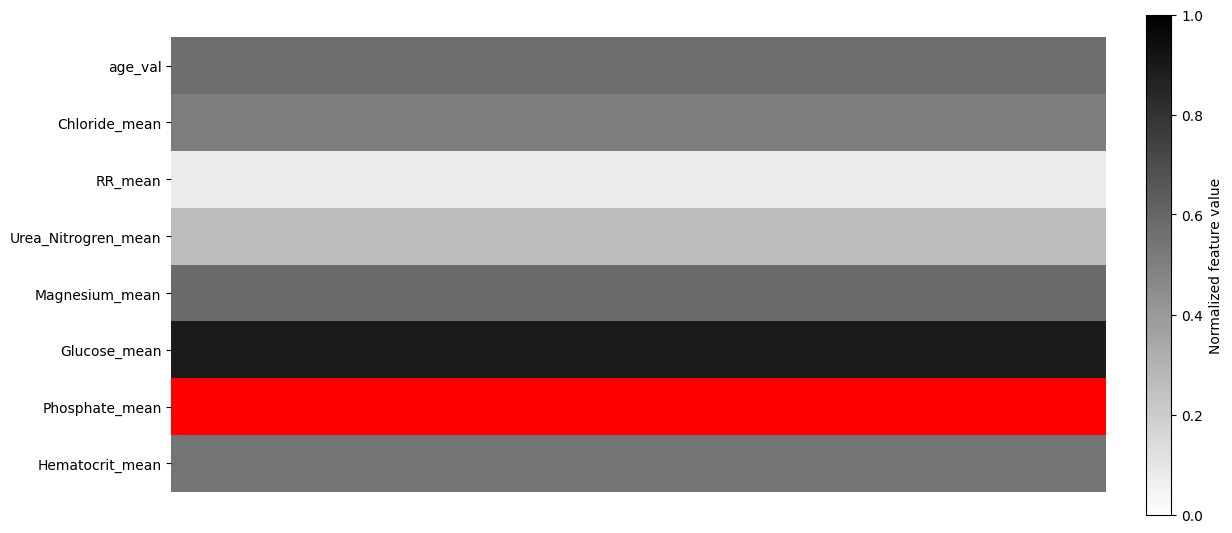

In [35]:
_ = npy_bar(df_cxr.iloc[[1]], colormap=plt.colormaps['binary'], add_label=True, add_colormap=True, verbose=True)

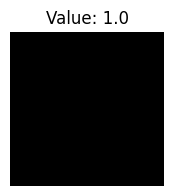

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_color_from_value(value):
    # Ensure the value is within the range [0, 1]
    if not (0 <= value <= 1):
        raise ValueError("Value must be between 0 and 1")
    
    # Create a colormap object
    cmap = plt.get_cmap('binary')
    
    # Get the color for the given value
    color = cmap(value)
    
    # Plot the color
    plt.figure(figsize=(2, 2))
    plt.imshow([[color]], interpolation='nearest')
    plt.axis('off')
    plt.title(f'Value: {value}')
    plt.show()

# Example usage
plot_color_from_value(1.0)  # Replace 0.5 with any value between 0 and 1

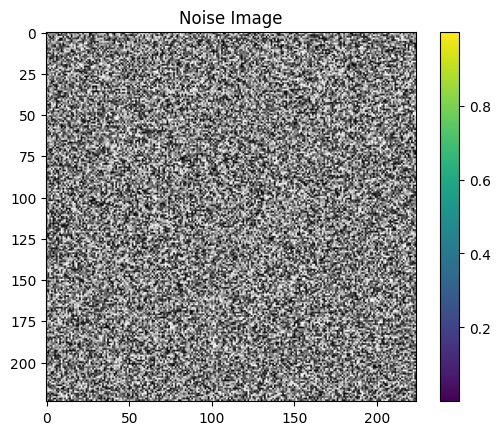

In [37]:
# Define the dimensions of the image
height, width = 224, 224

# Generate random noise
noise = np.random.random((height, width))
noise = np.expand_dims(noise, axis=2).repeat(3, axis=2)

# Display the noise image
plt.imshow(noise)
plt.colorbar()
plt.title('Noise Image')
plt.show()